### Show final calibration results
This notebook takes the final calibration results from quoFEM and plots the response of the system for samples of the calibrated parameters


In [104]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
import time

In [105]:
# Local working directory (quoFEM)
localworkdir = r'C:\Users\Miguel.MIGUEL-DESK\Documents\quoFEM\LocalWorkDir\tmp.SimCenter'

# Explore files
os.listdir(localworkdir)

['cal_260.csv',
 'dakotaTab.out',
 'dakotaTabPrior.out',
 'log.txt',
 'logFileTMCMC.txt',
 'quoFEMTempCalibrationDataFile.cal',
 'response.csv',
 'resultsStage0.csv',
 'resultsStage1.csv',
 'resultsStage10.csv',
 'resultsStage11.csv',
 'resultsStage12.csv',
 'resultsStage13.csv',
 'resultsStage2.csv',
 'resultsStage3.csv',
 'resultsStage4.csv',
 'resultsStage5.csv',
 'resultsStage6.csv',
 'resultsStage7.csv',
 'resultsStage8.csv',
 'resultsStage9.csv',
 'templatedir',
 'UCSD_UQ.err',
 'workdir.1',
 'workdir.10',
 'workdir.100',
 'workdir.101',
 'workdir.102',
 'workdir.103',
 'workdir.104',
 'workdir.105',
 'workdir.106',
 'workdir.107',
 'workdir.108',
 'workdir.109',
 'workdir.11',
 'workdir.110',
 'workdir.111',
 'workdir.112',
 'workdir.113',
 'workdir.114',
 'workdir.115',
 'workdir.116',
 'workdir.117',
 'workdir.118',
 'workdir.119',
 'workdir.12',
 'workdir.120',
 'workdir.121',
 'workdir.122',
 'workdir.123',
 'workdir.124',
 'workdir.125',
 'workdir.126',
 'workdir.127',
 'wo

In [106]:
# Load all data
cal_data = pd.read_csv(localworkdir + r'\response.csv')

# Extract columns 2 to 14
cal_data = cal_data.iloc[:, 2:14]
cal_data.head()

,gamma,eta1,sig,lam,mup,sigp,rsmax,alpha,alpha1,alpha2,betam1,kappa
0,0.631586,1.689850,0.387906,0.492792,3.244376,4.272648,0.901706,0.000485,4.519899,0.125306,0.000025,0.889381
1,0.667417,2.760024,0.313687,0.528306,1.472913,4.687365,0.890364,0.000187,1.553550,0.463681,0.000017,0.923702
2,0.673408,3.263737,0.319678,0.644563,4.057079,2.511401,0.629036,0.001342,1.737095,0.347586,0.000152,0.896226
3,0.612583,3.561226,0.470038,0.656751,2.536401,1.366030,0.857820,0.001354,4.337146,0.360161,0.000053,0.870577
4,0.656567,2.465792,0.469881,0.651876,3.107695,1.729887,0.957163,0.001021,3.645266,0.889232,0.000045,0.895266


In [107]:
# Import functions to create model
from column_model.material_models import *
from column_model.structure_model import *
from column_model.utilities import *

In [108]:
# Load the test data
testid = 260


In [109]:
def get_response(model_params, testid):

    # Get parameters into individual variables
    gamma = model_params['gamma']
    eta1 = model_params['eta1']
    sig = model_params['sig']
    lam = model_params['lam']
    mup = model_params['mup']
    sigp = model_params['sigp']
    rsmax = model_params['rsmax']
    alpha = model_params['alpha']
    alpha1 = model_params['alpha1']
    alpha2 = model_params['alpha2']
    betam1 = model_params['betam1']
    kappa = model_params['kappa']

    filesdir = r'C:\Users\Miguel.MIGUEL-DESK\Documents\GitHub\RC_Column_Model\test_data'
    with open(filesdir + '/test_' + str(testid).zfill(3) + '.json') as file:
        test_data = json.load(file)

    # Get the effective force of the test, if needed
    test_data["data"] = get_effective_force(test_data)
        
    # Define the elastic properties of the column
    E, I, L = get_elastic_properties(test_data)
        
    # Stiffness and strength of the plastic hinge
    stiffness =  10 * 3 * E * I / L   # kN-mm
    strength = 1000 * np.max(test_data["data"]["force"]) * L
        
    # Stiffness and strength of the plastic hinge (no need to update)
    k0 = stiffness
    sy0 = kappa * strength

    # Put them all in a list
    n = 2.0
    deg_bw_params = [eta1, k0, sy0, sig, lam, mup, sigp, rsmax, n, alpha, alpha1, alpha2, betam1]

    #% Create Plastic Hinge
    my_ph = deg_bw_material(deg_bw_params)

    # Elastic Parameters, mass and additional damping
    el_params = [gamma * E * I, L]   # [EI, L]
    mass = np.array([522, 1.0, 3.62e6])   # kips/g
    damping = [0.01]

    # Create structural model
    model = structure_model(el_params, my_ph, mass, damping)

    # Define the strains for the pushover analysis
    strains = np.array(test_data["data"]["disp"])
    #print(len(strains))

    # Define cycles for pushover
    t0 = time.time()
    force = run_pushover(model, strains, plot=False, show_info=False)
    t1 = time.time()

    print('Finished... Run Time = ', t1-t0, 'sec')

    peak_force = np.max(force)

    return strains, force, peak_force, L, test_data

Need to compute effective force
Running Eigenvalue Analysis ... 
Eigenvalue Analysis Done 

Finished... Run Time =  1.1257586479187012 sec
Need to compute effective force
Running Eigenvalue Analysis ... 
Eigenvalue Analysis Done 

Finished... Run Time =  1.1498947143554688 sec
Need to compute effective force
Running Eigenvalue Analysis ... 
Eigenvalue Analysis Done 

Finished... Run Time =  1.1965007781982422 sec
Need to compute effective force
Running Eigenvalue Analysis ... 
Eigenvalue Analysis Done 

Finished... Run Time =  1.0611250400543213 sec
Need to compute effective force
Running Eigenvalue Analysis ... 
Eigenvalue Analysis Done 

Finished... Run Time =  1.2174232006072998 sec
Need to compute effective force
Running Eigenvalue Analysis ... 
Eigenvalue Analysis Done 

Finished... Run Time =  1.0422067642211914 sec
Need to compute effective force
Running Eigenvalue Analysis ... 
Eigenvalue Analysis Done 

Finished... Run Time =  1.2160038948059082 sec
Need to compute effective f

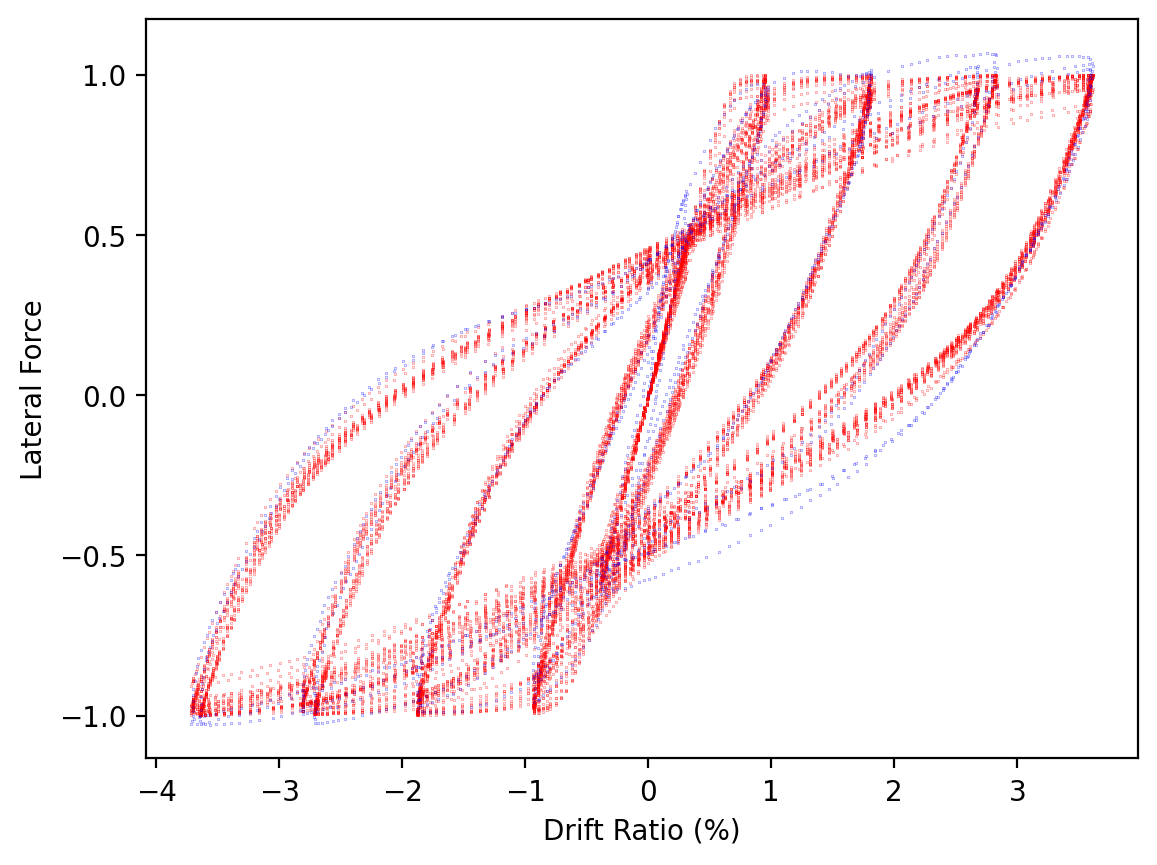

In [110]:
# Sample 10 random rows
model_params_mat = cal_data.sample(10, random_state=2)
testid = 260

plt.figure(dpi=200)

for ii in range(0, len(model_params_mat)):
    model_params = model_params_mat.iloc[ii, :]

    # print(model_params)
    strains, force, peak_force, L, test_data = get_response(model_params, testid)

    plt.plot(100 * np.array(strains)/L, np.array(force)/peak_force, 'r.', markersize=0.2)
    plt.xlabel('Drift Ratio (%)')
    plt.ylabel('Lateral Force')

#plt.figure()
plt.plot(100 * np.array(test_data["data"]["disp"])/L, 1000 * np.array(test_data["data"]["force"])/peak_force, 'b.', markersize=0.2)
plt.show()